The purpose of this notebook is to test whether there are gene expression differences between EUR and EAS cell lines for the ancestry-associated genes.

In [3]:
#Load packages
library(tidyverse)
library(reshape2)
library(ggrepel)

#Load functions
show_msg <- function(x){ 
    print(x)
    flush.console()
}

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




In [2]:
#First, load in the statistics data from the New_Ancestry_Associated_Dependencies
setwd('/home/jupyter/Ancestry/ccle_ancestry_analysis')
ancestry.associations = read.table("ancestry.associated.gene.associations.txt", sep = "\t", header = T)

In [7]:
#Get a list of the significant genes
significant.genes = ancestry.associations %>%
filter(FDR < 0.05) %>%
pull(gene) %>%
unique()

length(significant.genes)
significant.genes

[1] 96

[1] "EEF2"      "NUP133"    "RESP18"    "ACAN"      "ADCY3"     "BTG1"     
 [7] "C22orf31"  "C2orf80"   "CBFA2T2"   "CCDC102B"  "CCDC74B"   "CCL3"     
[13] "CEP19"     "CHGB"      "CLSPN"     "COX6B1"    "DCN"       "DDX47"    
[19] "DND1"      "ECD"       "EGFR"      "FAM25A"    "FCGR3A"    "FRG2C"    
[25] "GLYCTK"    "GRB2"      "GTPBP3"    "HCN2"      "HINT3"     "HIST1H2AA"
[31] "HLA"       "HNF1B"     "INCENP"    "ITGA3"     "ITIH3"     "KIAA2013" 
[37] "KRTAP3"    "MATR3"     "MRTO4"     "MYH11"     "NAA40"     "NIT2"     
[43] "NKAIN4"    "NOP56"     "NPEPPS"    "NPHS1"     "PDXDC1"    "PEX11A"   
[49] "PTPN11"    "QRICH2"    "RAB21"     "RETNLB"    "RHD"       "RIMS2"    
[55] "RPL3"      "RPS5"      "RTP5"      "SART1"     "SCN5A"     "SLC10A5"  
[61] "SLC35B2"   "SLC38A7"   "SLC5A11"   "SNAP23"    "SPATA6L"   "SRP14"    
[67] "STX4"      "STXBP3"    "TPSD1"     "TRMT61B"   "TTC4"      "TUT1"     
[73] "TXNRD1"    "UGT2B17"   "VRK1"      "WSB2"      "ZNF675"    "APEX2"    
[79] "ATRX"      "C17orf64"  "COPG1"     "CSE1L"     "DEFB108B"  "ERI1"     
[85] "FAM86C1"   "IL1RN"     "KRT14"     "LPAR6"     "MDN1"      "NOMO2"    
[91] "PCBP4"     "PSPH"      "RPP30"     "SERINC2"   "XYLT2"     "ZFP62"

In [15]:
#Load in the ancestry information
setwd('/home/jupyter/Ancestry/rfmix')
ancestry.information = read.table("collapsed.ancestry.information.txt", sep = "\t", header = T)

#Get list of the EUR and EAS cell lines
eur.lines = ancestry.information %>% filter(EUR >= 0.8) %>% pull(sample)
eas.lines = ancestry.information %>% filter(EAS >= 0.8) %>% pull(sample)

head(ancestry.information)

,sample,AFR,AMR,EAS,EUR,SAS
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ACH-000657,0.9601677273,0.0005504545,0.0063213636,0.03192409,0.0010363636
2,ACH-000617,0.0028859091,0.0204050000,0.0000000000,0.97557545,0.0011336364
3,ACH-000685,0.8539895455,0.0272740909,0.0395313636,0.07403591,0.0051686364
4,ACH-000632,0.0025995455,0.0009922727,0.0001513636,0.99553364,0.0007231818
5,ACH-000171,0.0007454545,0.0000000000,0.0010822727,0.99686682,0.0013054545
6,ACH-000863,0.0065409091,0.0000000000,0.0036922727,0.96728000,0.0224868182


In [8]:
#Load in the CCLE gene expression data
setwd('/home/jupyter/Ancestry/raw_data/depmap/avana14')
ccle.expression = read.table('CCLE_expression.csv', sep = ",", header = T, check.names = FALSE) %>%
rename( "sample" = 1) %>%
setNames(word(names(.), 1)) 

Now that all of the data is loaded, let's calculate the associations

In [20]:
#Not all of the CRISPR genes are in the expression dataset, so let's create an intersecting list of genes that we need to grab from the expression dataset.
genes.to.grab = intersect(colnames(ccle.expression), significant.genes)

#Filter the CCLE expression data so that it only includes the ancestry-associated genes
filtered.expression = ccle.expression %>%
select(sample, all_of(genes.to.grab)) %>%
filter(sample %in% c(eur.lines, eas.lines))

#Divide the dataset into a EUR dataset and an EAS dataset 
eur.filtered.expression = filtered.expression %>% filter(sample %in% eur.lines) %>% select(-sample)
eas.filtered.expression = filtered.expression %>% filter(sample %in% eas.lines) %>% select(-sample)

In [24]:
#Now that those datasets are made, let's calculate the p-values between the two groups.
expression.difference.pvals = mapply(wilcox.test, x = eur.filtered.expression, y = eas.filtered.expression) %>% data.frame() %>% slice(3) %>% unlist()

#Also get the expression differences
eur.mean.expression = eur.filtered.expression %>% apply(2, mean, na.rm = TRUE)
eas.mean.expression = eas.filtered.expression %>% apply(2, mean, na.rm = TRUE)
differential.mean.expression = eur.mean.expression - eas.mean.expression

,gene,expression_difference,pval,FDR
,<chr>,<dbl>,<dbl>,<dbl>
PDXDC1,PDXDC1,0.3816276,3.171107e-14,2.917419e-12
UGT2B17,UGT2B17,0.1110812,1.040050e-09,4.784232e-08
IL1RN,IL1RN,-0.5329302,4.010039e-09,9.223091e-08
RHD,RHD,-0.1370311,3.038629e-09,9.223091e-08
CLSPN,CLSPN,0.3755298,9.415514e-08,1.732455e-06
INCENP,INCENP,0.2300572,1.858626e-06,2.849893e-05


'data.frame':	92 obs. of  4 variables:
 $ gene                 : chr  "PDXDC1" "UGT2B17" "IL1RN" "RHD" ...
 $ expression_difference: num  0.382 0.111 -0.533 -0.137 0.376 ...
 $ pval                 : num  3.17e-14 1.04e-09 4.01e-09 3.04e-09 9.42e-08 ...
 $ FDR                  : num  2.92e-12 4.78e-08 9.22e-08 9.22e-08 1.73e-06 ...


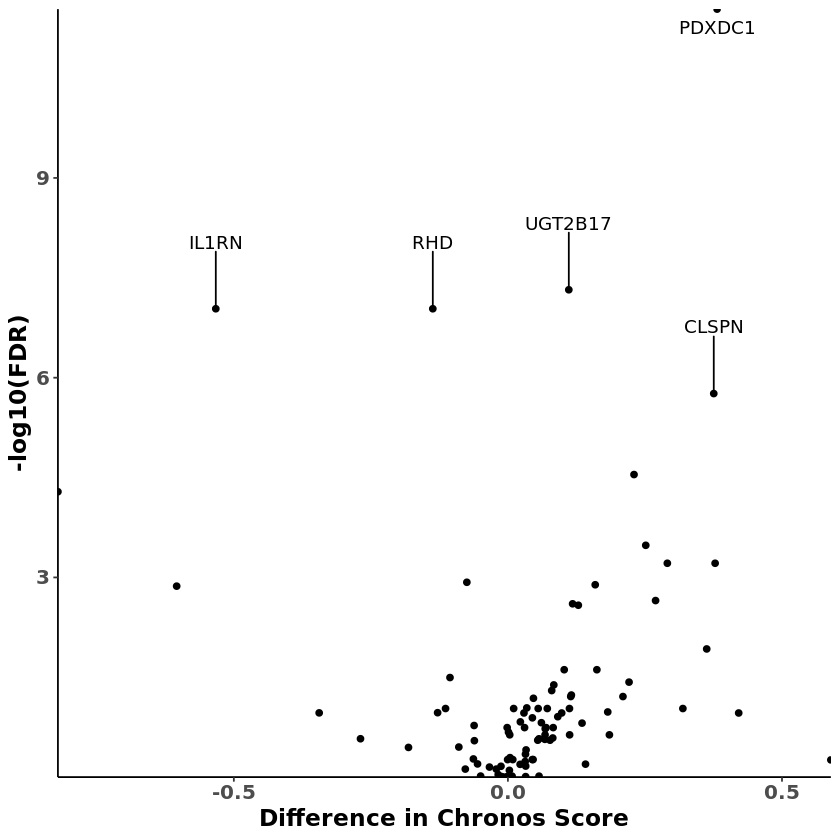

In [40]:
#Bind everything into a single dataset and draw the volcano plot
expression.differences.df = cbind(names(differential.mean.expression), differential.mean.expression, expression.difference.pvals) %>%
data.frame() %>%
rename("gene" = 1, "expression_difference" = 2, "pval" = 3) %>%
mutate(pval = as.numeric(pval)) %>%
mutate(expression_difference = as.numeric(expression_difference)) %>%
mutate(FDR = p.adjust(pval, method = "BH", n = length(pval))) %>%
arrange(FDR)
head(expression.differences.df)
str(expression.differences.df)


#Now finally plot the volcano plot
expression.differences.df %>%
ggplot(aes(x = expression_difference, y = -log10(FDR))) +
geom_point(aes(x = expression_difference, y = -log10(FDR))) +

theme_bw() +

theme(
panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(color = "black")
) +

theme(
axis.title.x = element_text(color = "black", size = 14, face = "bold"),
axis.title.y = element_text(color = "black", size = 14, face = "bold")
) +

theme(
axis.text=element_text(size = 12, face = "bold"),
axis.title=element_text(size = 14,face = "bold")
) +

theme(
legend.title = element_text(size = 14, face = "bold"),
legend.text = element_text(size = 10, face = "bold")
) +

ylab("-log10(FDR)") +
xlab("Difference in Chronos Score") +
labs(fill='Ancestry Group') +
scale_y_continuous(expand = c(0,0)) +
scale_x_continuous(expand = c(0,0)) +

geom_text_repel(
aes(label=ifelse(-log10(FDR) > 5, 
as.character(gene),'')), 
box.padding = 0.5,
nudge_y = 1,
segment.ncp = 3,
segment.angle = 20)

In [46]:
#Now draw boxplots for our favorite genes

#Make a vector that has our favorite genes in it
favorite.genes = c("CLSPN", "RHD", "INCENP", "RPS5", "UGT2B17", "SRP14")

#Generate a dataset for plotting our favorite genes
df.for.boxplot = ccle.expression %>%
select(sample, all_of(favorite.genes)) %>%
inner_join(., ancestry.information, by = "sample") %>%
mutate(ancestry = ifelse(EUR >= 0.8, "EUR", ifelse(EAS >= 0.8, "EAS", "Other"))) %>%
filter(ancestry %in% c("EUR", "EAS")) %>%
select(sample, all_of(favorite.genes), ancestry) %>%
melt()

head(df.for.boxplot)
dim(df.for.boxplot)

Using sample, ancestry as id variables



,sample,ancestry,variable,value
,<chr>,<chr>,<fct>,<dbl>
1,ACH-001113,EAS,CLSPN,4.441616
2,ACH-000242,EUR,CLSPN,4.855990
3,ACH-000708,EAS,CLSPN,3.145677
4,ACH-000327,EUR,CLSPN,2.691534
5,ACH-000233,EUR,CLSPN,3.509696
6,ACH-000461,EAS,CLSPN,4.073820


[1] 5142    4

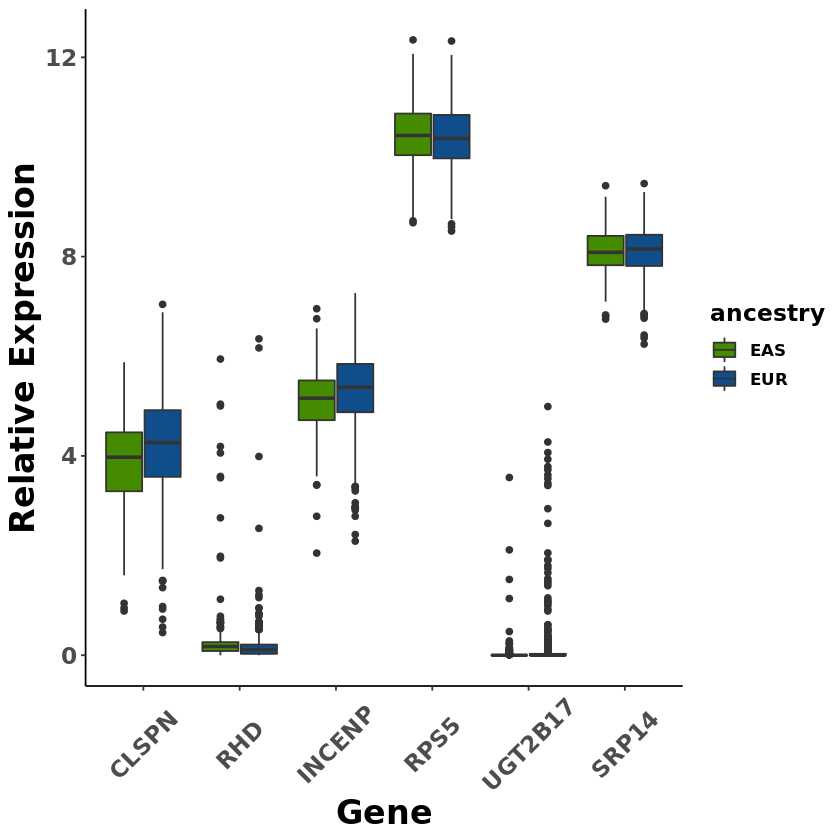

In [49]:
#Now generate the boxplot

set.seed(42)
group.colors <- c("EAS" = "chartreuse4", "EUR" = "dodgerblue4") #Make the color vector

df.for.boxplot %>%
ggplot() +
geom_boxplot(position=position_dodge(0.8), aes(x = variable, y = value, fill = ancestry)) +
scale_fill_manual(values = group.colors) +

theme_bw() +

theme(
panel.border = element_blank(), 
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
axis.line = element_line(color = "black")
) +

theme(
axis.text.x = element_text(face="bold", size=14),
axis.text.y = element_text(face="bold", size=14)
) +

theme(
panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(color = "black")
) +

theme(
axis.title.x = element_text(color = "black", size = 20, face = "bold"),
axis.title.y = element_text(color = "black", size = 20, face = "bold")
) +

theme(
axis.text=element_text(size = 14, face = "bold"),
) +

theme(
legend.title = element_text(size = 14, face = "bold"),
legend.text = element_text(size = 10, face = "bold")
) +

theme(
axis.text.x = element_text(angle = 45, vjust = 0.5, hjust = 0.5)
) +

xlab("Gene") +
ylab("Relative Expression") 

#Put the exported image into the google bucket
setwd('/home/jupyter/Ancestry/figures')
ggsave("ancestry_association_expression.pdf", width = 5, height = 3)
system(glue::glue("
cd /home/jupyter/Ancestry/figures
gsutil cp ancestry_association_expression.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

Let's make a plot that shows the expression value distribution for all of the ancestry-associated genes.

In [10]:
#Get a list of all of the significant genes
setwd('/home/jupyter/Ancestry/ccle_ancestry_analysis')
ancestry.genes = read.table("ancestry.associated.gene.associations.txt", sep = "\t", header = T) %>%
filter(FDR < 0.05) %>%
pull(gene) %>%
unique()

ancestry.genes
length(ancestry.genes)

[1] "EEF2"      "NUP133"    "RESP18"    "ACAN"      "ADCY3"     "BTG1"     
 [7] "C22orf31"  "C2orf80"   "CBFA2T2"   "CCDC102B"  "CCDC74B"   "CCL3"     
[13] "CEP19"     "CHGB"      "CLSPN"     "COX6B1"    "DCN"       "DDX47"    
[19] "DND1"      "ECD"       "EGFR"      "FAM25A"    "FCGR3A"    "FRG2C"    
[25] "GLYCTK"    "GRB2"      "GTPBP3"    "HCN2"      "HINT3"     "HIST1H2AA"
[31] "HLA"       "HNF1B"     "INCENP"    "ITGA3"     "ITIH3"     "KIAA2013" 
[37] "KRTAP3"    "MATR3"     "MRTO4"     "MYH11"     "NAA40"     "NIT2"     
[43] "NKAIN4"    "NOP56"     "NPEPPS"    "NPHS1"     "PDXDC1"    "PEX11A"   
[49] "PTPN11"    "QRICH2"    "RAB21"     "RETNLB"    "RHD"       "RIMS2"    
[55] "RPL3"      "RPS5"      "RTP5"      "SART1"     "SCN5A"     "SLC10A5"  
[61] "SLC35B2"   "SLC38A7"   "SLC5A11"   "SNAP23"    "SPATA6L"   "SRP14"    
[67] "STX4"      "STXBP3"    "TPSD1"     "TRMT61B"   "TTC4"      "TUT1"     
[73] "TXNRD1"    "UGT2B17"   "VRK1"      "WSB2"      "ZNF675"    "APEX2"    
[79] "ATRX"      "C17orf64"  "COPG1"     "CSE1L"     "DEFB108B"  "ERI1"     
[85] "FAM86C1"   "IL1RN"     "KRT14"     "LPAR6"     "MDN1"      "NOMO2"    
[91] "PCBP4"     "PSPH"      "RPP30"     "SERINC2"   "XYLT2"     "ZFP62"

[1] 96

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



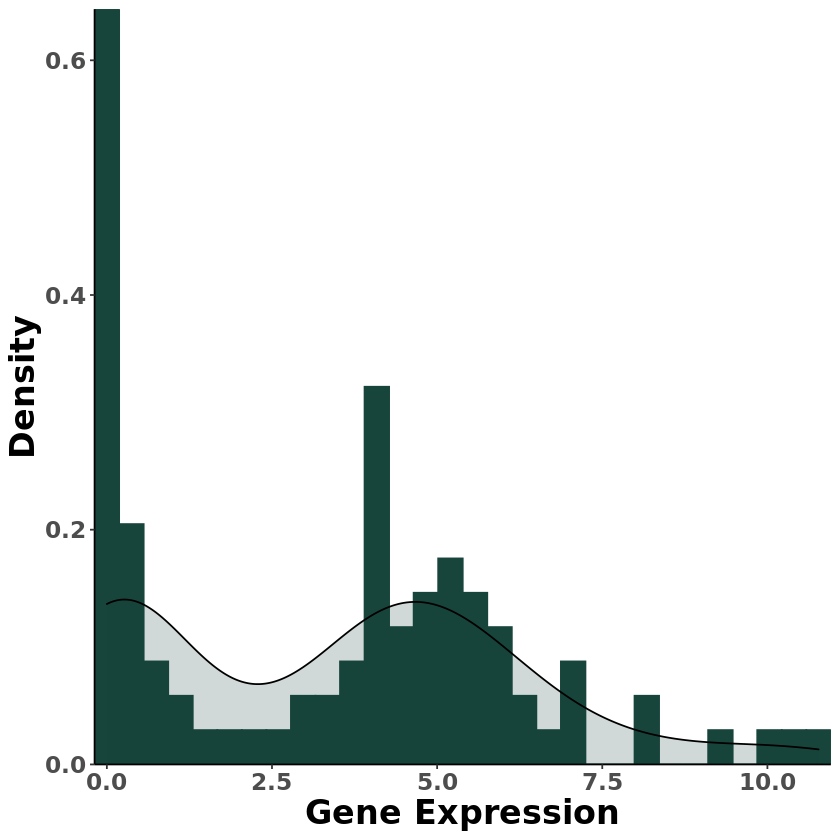

In [45]:
#Get all of the genes that we want to keep
genes.to.keep = intersect(ancestry.genes, colnames(ccle.expression))

#Get the median expression value for all of the ancestry-associated genes.
ancestry.expression.medians = ccle.expression %>%
select(all_of(genes.to.keep)) %>%
apply(2, median) %>%
data.frame() %>%
rename("expression" = 1)

ancestry.expression.medians %>%
ggplot(aes(x = expression)) +
geom_histogram(aes(y=..density..), color = rgb(24, 69, 59, maxColorValue = 255), fill = rgb(24, 69, 59, maxColorValue = 255)) +
geom_density(alpha=.2, fill = rgb(24, 69, 59, maxColorValue = 255)) +

theme_bw() +

theme(
panel.border = element_blank(), 
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
axis.line = element_line(color = "black")
) +

theme(
axis.text.x = element_text(face="bold", size=14),
axis.text.y = element_text(face="bold", size=14)
) +

theme(
panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(color = "black")
) +

theme(
axis.title.x = element_text(color = "black", size = 20, face = "bold"),
axis.title.y = element_text(color = "black", size = 20, face = "bold")
) +

theme(
axis.text=element_text(size = 14, face = "bold"),
) +

theme(
legend.title = element_text(size = 14, face = "bold"),
legend.text = element_text(size = 10, face = "bold")
) +

scale_y_continuous(expand = c(0,0)) +
scale_x_continuous(expand = c(0,0)) +

xlab("Gene Expression") +
ylab("Density") 

#Put the exported image into the google bucket
setwd('/home/jupyter/Ancestry/figures')
ggsave("all_expression_values.pdf", width = 5, height = 3)
system(glue::glue("
cd /home/jupyter/Ancestry/figures
gsutil cp all_expression_values.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))


In [52]:
#Calculate the number of genes that have a median expression value above 2.5
above.value = ancestry.expression.medians[ancestry.expression.medians > 2.5]
length(above.value)/nrow(ancestry.expression.medians)

[1] 0.5978261